In [1]:
from matplotlib import set_loglevel

figPath = '../img/'
figExt  = 'eps'

set_loglevel('error')

# Load and View Data

Number of data points: 200
k in [0, 199]


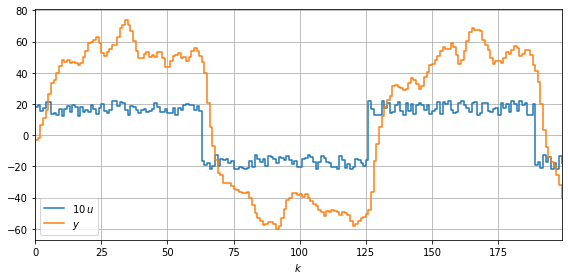

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='$10\,u$', drawstyle='steps-post')
plt.plot(k, y   , label='$y$'    , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(figPath + 'data.' + figExt, format=figExt)
plt.show()

## Input Fourier Transform

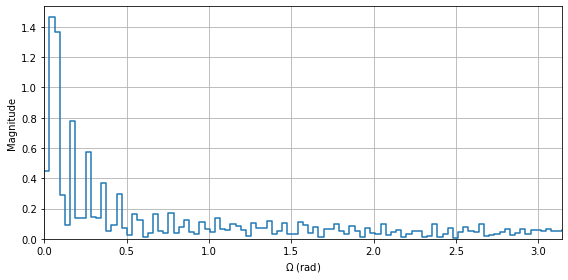

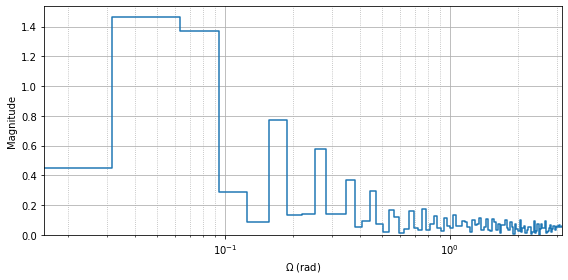

In [3]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.ylim(0)
plt.xlabel('$\\Omega$ (rad)')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.savefig(figPath + 'data_fourier.' + figExt, format=figExt)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xscale('log')
plt.xlim(Omega[1]/2, Omega[-1])
plt.ylim(0)
plt.xlabel('$\\Omega$ (rad)')
plt.ylabel('Magnitude')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.tight_layout()
plt.savefig(figPath + 'data_fourier_log.' + figExt, format=figExt)
plt.show()

## Separate Identification and Validation Data

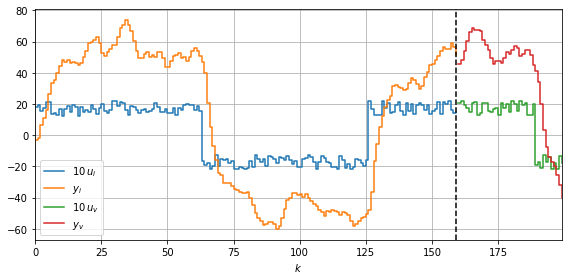

In [4]:
N_fold = 160

k_i = k[:N_fold]
u_i = u[:N_fold]
y_i = y[:N_fold]

k_v = k[N_fold:]
u_v = u[N_fold:]
y_v = y[N_fold:]

plt.figure(figsize=(8,4))
plt.plot(k_i, 10*u_i, label='$10\,u_i$', drawstyle='steps-post')
plt.plot(k_i, y_i   , label='$y_i$'    , drawstyle='steps-post')
plt.plot(k_v, 10*u_v, label='$10\,u_v$', drawstyle='steps-post')
plt.plot(k_v, y_v   , label='$y_v$'    , drawstyle='steps-post')
plt.axvline(k[N_fold-1], color='black', linestyle='--')
plt.xlim(k[0], k[-1])
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(figPath + 'data_folded.' + figExt, format=figExt)
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

## Prediction Error Method

\begin{gather*}
\hat{y}[k] = L_u(q) \, u[k] + L_y(q) \, y[k]
\\
L_u(q) = \dfrac{G(q)}{H(q)}
\\
L_y(q) = 1 - \dfrac{1}{H(q)}
\end{gather*}

## Prediction Cost

\begin{gather*}
  \hat{J} = \dfrac{1}{N} \sum_{k=1}^N \left(y[k] - \hat{y}[k]\right)^2
\end{gather*}

# ARX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\end{gather*}

\begin{gather*}
n_a = \{0, 1, 2, 3\}
\qquad
n_b = \{0, 1, 2\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [5]:
from functions import arx

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nk_range = range(1, 3 + 1)

models_arx = arx(u_i, y_i, u_v, y_v, na_range, nb_range, nk_range)

## Display Best 

In [6]:
from functions import display_models

columns=[
  'na', 'nb', 'nk',
  'Jv', 'Ji',
  'AICv', 'AICCv',
  'AICi', 'AICCi',
  'A', 'B',
]

for criterion in ['Jv', 'AICCv', 'AICCi']:
  display_models(models_arx.sort_values(by=[criterion]), precision=3, qty=6, columns=columns)

,na,nb,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B
0,3,1,1,5.556,5.740,78.594,80.358,289.581,289.971,[ 1. -1.352 0.503 -0.046],[0. 2.143 0.873]
0,2,2,1,5.589,5.276,78.832,80.596,276.114,276.503,[ 1. -1.407 0.483],[ 0. 2.162 1.611 -1.602]
0,3,2,1,5.634,5.275,81.153,83.698,278.076,278.625,[ 1. -1.399 0.463 0.012],[ 0. 2.156 1.624 -1.623]
0,2,1,1,5.801,5.750,78.320,79.463,287.883,288.142,[ 1. -1.31 0.417],[0. 2.142 0.941]
0,3,0,1,6.074,5.875,80.160,81.303,291.314,291.572,[ 1. -1.415 0.557 -0.051],[0. 2.605]
0,2,0,1,6.384,5.910,80.153,80.820,290.269,290.423,[ 1. -1.371 0.464],[0. 2.656]


,na,nb,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B
0,2,1,1,5.801,5.750,78.320,79.463,287.883,288.142,[ 1. -1.31 0.417],[0. 2.142 0.941]
0,3,1,1,5.556,5.740,78.594,80.358,289.581,289.971,[ 1. -1.352 0.503 -0.046],[0. 2.143 0.873]
0,2,2,1,5.589,5.276,78.832,80.596,276.114,276.503,[ 1. -1.407 0.483],[ 0. 2.162 1.611 -1.602]
0,2,0,1,6.384,5.910,80.153,80.820,290.269,290.423,[ 1. -1.371 0.464],[0. 2.656]
0,3,0,1,6.074,5.875,80.160,81.303,291.314,291.572,[ 1. -1.415 0.557 -0.051],[0. 2.605]
0,3,2,1,5.634,5.275,81.153,83.698,278.076,278.625,[ 1. -1.399 0.463 0.012],[ 0. 2.156 1.624 -1.623]


,na,nb,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B
0,2,2,1,5.589,5.276,78.832,80.596,276.114,276.503,[ 1. -1.407 0.483],[ 0. 2.162 1.611 -1.602]
0,3,2,1,5.634,5.275,81.153,83.698,278.076,278.625,[ 1. -1.399 0.463 0.012],[ 0. 2.156 1.624 -1.623]
0,2,1,1,5.801,5.750,78.320,79.463,287.883,288.142,[ 1. -1.31 0.417],[0. 2.142 0.941]
0,3,1,1,5.556,5.740,78.594,80.358,289.581,289.971,[ 1. -1.352 0.503 -0.046],[0. 2.143 0.873]
0,2,0,1,6.384,5.910,80.153,80.820,290.269,290.423,[ 1. -1.371 0.464],[0. 2.656]
0,3,0,1,6.074,5.875,80.160,81.303,291.314,291.572,[ 1. -1.415 0.557 -0.051],[0. 2.605]


# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 + a_1 \, q^{-1} + \dotsb + a_{n_a} \, q^{-n_a}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

\begin{gather*}
n_a = \{0, 1, 2, 3\}
\qquad
n_b = \{0, 1, 2\}
\qquad
n_c = \{1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [7]:
from functions import armax

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nc_range = range(1, 3 + 1)
nk_range = range(1, 3 + 1)

models_armax = armax(u_i, y_i, u_v, y_v, na_range, nb_range, nc_range, nk_range)

## Display Best 

In [8]:
from functions import display_models

columns=[
  'na', 'nb', 'nc', 'nk',
  'Jv', 'Ji',
  'AICv', 'AICCv',
  'AICi', 'AICCi',
  'A', 'B', 'C',
]

for criterion in ['Jv', 'AICCv', 'AICCi']:
  display_models(models_armax.sort_values(by=[criterion]), precision=3, qty=6, columns=columns)

,na,nb,nc,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B,C
0,2,2,1,1,5.579,5.277,80.757,83.302,278.136,278.685,[ 1. -1.395 0.473],[ 0. 2.102 1.725 -1.602],[1. 0.022]
0,3,1,1,1,5.814,5.479,82.410,84.955,284.143,284.692,[ 1. -0.74 -0.37 0.272],[0. 1.856 2.75 ],[1. 0.588]
0,3,2,1,1,5.832,5.260,84.536,88.036,279.632,280.369,[ 1. -1.248 0.249 0.089],[ 0. 2.069 2.032 -1.534],[1. 0.159]
0,3,0,1,1,5.853,5.802,80.675,82.440,291.308,291.698,[ 1. -1.582 0.822 -0.158],[0. 2.368],[ 1. -0.188]
0,1,2,1,1,6.021,5.902,81.809,83.574,294.060,294.450,[ 1. -0.84],[ 0. 2.239 2.843 -0.368],[1. 0.434]
0,2,1,1,1,6.237,5.652,83.218,84.983,287.114,287.503,[ 1. -1.159 0.288],[0. 1.975 1.754],[1. 0.203]


,na,nb,nc,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B,C
0,2,0,1,1,6.244,5.905,81.264,82.406,292.128,292.387,[ 1. -1.4 0.489],[0. 2.537],[ 1. -0.04]
0,3,0,1,1,5.853,5.802,80.675,82.440,291.308,291.698,[ 1. -1.582 0.822 -0.158],[0. 2.368],[ 1. -0.188]
0,2,2,1,1,5.579,5.277,80.757,83.302,278.136,278.685,[ 1. -1.395 0.473],[ 0. 2.102 1.725 -1.602],[1. 0.022]
0,1,2,1,1,6.021,5.902,81.809,83.574,294.060,294.450,[ 1. -0.84],[ 0. 2.239 2.843 -0.368],[1. 0.434]
0,3,1,1,1,5.814,5.479,82.410,84.955,284.143,284.692,[ 1. -0.74 -0.37 0.272],[0. 1.856 2.75 ],[1. 0.588]
0,2,1,1,1,6.237,5.652,83.218,84.983,287.114,287.503,[ 1. -1.159 0.288],[0. 1.975 1.754],[1. 0.203]


,na,nb,nc,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,A,B,C
0,1,1,2,1,12.835,5.109,112.086,113.851,270.950,271.339,[ 1. -0.825],[0. 2.112 2.98 ],[1. 0.554 0.404]
0,1,1,3,1,12.067,5.067,111.619,114.164,271.633,272.182,[ 1. -0.821],[0. 2.134 3.023],[1. 0.619 0.487 0.115]
0,2,1,2,1,12.534,5.103,113.139,115.684,272.781,273.330,[ 1. -0.866 0.038],[0. 2.111 2.869],[1. 0.521 0.395]
0,2,1,3,1,12.716,5.059,115.715,119.215,273.389,274.126,[ 1. -0.764 -0.052],[0. 2.13 3.168],[1. 0.677 0.524 0.143]
0,1,2,2,1,12.847,5.130,114.125,116.670,273.610,274.159,[ 1. -0.83],[ 0. 2.12 2.995 -0.172],[1. 0.55 0.403]
0,1,2,3,1,12.299,5.063,114.381,117.881,273.515,274.252,[ 1. -0.826],[ 0. 2.132 3.027 -0.132],[1. 0.615 0.485 0.113]


# Output Error

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

\begin{gather*}
n_b = \{0, 1, 2\}
\qquad
n_f = \{1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [9]:
from functions import oe

nb_range = range(0, 2 + 1)
nf_range = range(1, 3 + 1) # nf = 0 causa erro no pysid!
nk_range = range(1, 3 + 1)

models_oe = oe(u_i, y_i, u_v, y_v, nb_range, nf_range, nk_range)

## Display Best 

In [10]:
from functions import display_models

columns=[
  'nb', 'nf', 'nk',
  'Jv', 'Ji',
  'AICv', 'AICCv',
  'AICi', 'AICCi',
  'B', 'F'
]

for criterion in ['Jv', 'AICCv', 'AICCi']:
  display_models(models_oe.sort_values(by=[criterion]), precision=3, qty=6, columns=columns)

,nb,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,F
0,2,2,2,167.747,49.550,214.898,216.663,634.478,634.868,[ 0. 0. 7.712 -6.907 0.287],[ 1. -1.524 0.56 ]
0,2,3,2,167.919,49.486,216.939,219.485,636.272,636.821,[ 0. 0. 7.978 -3.229 -3.063],[ 1. -0.952 -0.32 0.327]
0,2,2,3,175.236,67.821,216.645,218.410,684.701,685.090,[ 0. 0. 0. 10.288 -9.679 0.938],[ 1. -1.402 0.453]
0,2,3,3,175.268,67.722,218.653,221.198,686.466,687.015,[ 0. 0. 0. 10.543 -5.089 -3.075],[ 1. -0.87 -0.285 0.235]
0,1,3,1,181.596,45.088,218.071,219.836,619.378,619.768,[ 0. 3.351 -2.766],[ 1. -2.178 1.626 -0.429]
0,2,2,1,184.146,45.628,218.629,220.394,621.283,621.672,[ 0. 3.506 -0.078 -2.606],[ 1. -1.601 0.627]


,nb,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,F
0,2,2,2,167.747,49.550,214.898,216.663,634.478,634.868,[ 0. 0. 7.712 -6.907 0.287],[ 1. -1.524 0.56 ]
0,2,2,3,175.236,67.821,216.645,218.410,684.701,685.090,[ 0. 0. 0. 10.288 -9.679 0.938],[ 1. -1.402 0.453]
0,2,1,2,187.493,51.560,217.350,218.492,638.840,639.098,[ 0. 0. 8.083 -1.784 -2.412],[ 1. -0.871]
0,2,1,3,187.670,69.074,217.387,218.530,685.628,685.886,[ 0. 0. 0. 10.619 -4.083 -2.733],[ 1. -0.872]
0,2,3,2,167.919,49.486,216.939,219.485,636.272,636.821,[ 0. 0. 7.978 -3.229 -3.063],[ 1. -0.952 -0.32 0.327]
0,1,2,2,193.488,50.238,218.609,219.751,634.684,634.942,[ 0. 0. 7.563 -6.424],[ 1. -1.51 0.547]


,nb,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,F
0,2,3,1,195.958,34.973,223.116,225.661,580.733,581.282,[ 0. 4.629 -8.623 4.305],[ 1. -2.759 2.61 -0.841]
0,1,3,1,181.596,45.088,218.071,219.836,619.378,619.768,[ 0. 3.351 -2.766],[ 1. -2.178 1.626 -0.429]
0,2,2,1,184.146,45.628,218.629,220.394,621.283,621.672,[ 0. 3.506 -0.078 -2.606],[ 1. -1.601 0.627]
0,2,1,1,212.090,48.582,222.280,223.423,629.320,629.578,[ 0. 3.781 2.805 -2.48 ],[ 1. -0.864]
0,0,3,1,206.540,49.143,221.220,222.363,631.156,631.414,[0. 2.989],[ 1. -1.648 1.167 -0.42 ]
0,0,1,1,280.649,50.512,229.484,229.808,631.553,631.630,[0. 4.524],[ 1. -0.849]


# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = q^{-n_k} \, \left(b_0 + b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b}\right)
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

\begin{gather*}
n_b = \{0, 1, 2\}
\qquad
n_c = \{0, 1, 2, 3\}
\qquad
n_d = \{0, 1, 2, 3\}
\qquad
n_f = \{0, 1, 2, 3\}
\qquad
n_k = \{1, 2, 3\}
\end{gather*}

In [ ]:
from functions import bj # diversos erros

nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(0, 3 + 1)
nf_range = range(0, 3 + 1)
nk_range = range(1, 3 + 1)

models_bj = bj(u_i, y_i, u_v, y_v, nb_range, nc_range, nd_range, nf_range, nk_range)

## Display Best 

In [12]:
from functions import display_models

columns=[
  'nb', 'nc', 'nd', 'nf', 'nk',
  'Jv', 'Ji',
  'AICv', 'AICCv',
  'AICi', 'AICCi',
  'B', 'C', 'D', 'F',
]

for criterion in ['Jv', 'AICCv', 'AICCi']:
  display_models(models_bj.sort_values(by=[criterion]), precision=3, qty=6, columns=columns)

,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,C,D,F
0,2,0,2,3,1,5.487,5.214,84.096,88.741,280.206,281.16,[ 0. 2.063 2.592 -0.655],[1.],[ 1. -1.44 0.551],[ 1. -0.97 0.072 0.034]
0,2,0,2,2,1,5.521,5.214,82.344,85.844,278.228,278.965,[0. 2.078 3.219 0.275],[1.],[ 1. -1.44 0.551],[ 1. -0.672 -0.139]
0,2,0,2,1,1,5.524,5.214,80.363,82.909,276.229,276.778,[ 0. 2.083 2.874 -0.198],[1.],[ 1. -1.44 0.551],[ 1. -0.838]
0,1,0,3,1,1,5.683,5.193,81.496,84.041,275.571,276.12,[0. 2.039 2.825],[1.],[ 1. -1.403 0.452 0.069],[ 1. -0.835]
0,2,0,3,3,1,5.693,5.139,87.573,93.573,279.896,281.096,[ 0. 2.037 2.559 -0.69 ],[1.],[ 1. -1.403 0.449 0.072],[ 1. -0.977 0.066 0.044]
0,2,0,3,1,1,5.721,5.14,83.766,87.266,275.913,276.65,[ 0. 2.065 2.847 -0.196],[1.],[ 1. -1.403 0.453 0.069],[ 1. -0.84]


,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,C,D,F
0,2,0,2,1,1,5.524,5.214,80.363,82.909,276.229,276.778,[ 0. 2.083 2.874 -0.198],[1.],[ 1. -1.44 0.551],[ 1. -0.838]
0,1,0,2,1,1,5.941,5.183,81.276,83.04,273.256,273.646,[0. 2.052 2.863],[1.],[ 1. -1.439 0.55 ],[ 1. -0.832]
0,1,0,3,1,1,5.683,5.193,81.496,84.041,275.571,276.12,[0. 2.039 2.825],[1.],[ 1. -1.403 0.452 0.069],[ 1. -0.835]
0,2,0,2,2,1,5.521,5.214,82.344,85.844,278.228,278.965,[0. 2.078 3.219 0.275],[1.],[ 1. -1.44 0.551],[ 1. -0.672 -0.139]
0,1,0,2,2,1,6.154,5.182,84.681,87.227,275.236,275.785,[0. 2.082 3.025],[1.],[ 1. -1.44 0.551],[ 1. -0.766 -0.06 ]
0,2,0,3,1,1,5.721,5.14,83.766,87.266,275.913,276.65,[ 0. 2.065 2.847 -0.196],[1.],[ 1. -1.403 0.453 0.069],[ 1. -0.84]


,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi,B,C,D,F
0,1,0,2,1,1,5.941,5.183,81.276,83.04,273.256,273.646,[0. 2.052 2.863],[1.],[ 1. -1.439 0.55 ],[ 1. -0.832]
0,1,0,2,2,1,6.154,5.182,84.681,87.227,275.236,275.785,[0. 2.082 3.025],[1.],[ 1. -1.44 0.551],[ 1. -0.766 -0.06 ]
0,1,0,3,1,1,5.683,5.193,81.496,84.041,275.571,276.12,[0. 2.039 2.825],[1.],[ 1. -1.403 0.452 0.069],[ 1. -0.835]
0,2,0,3,1,1,5.721,5.14,83.766,87.266,275.913,276.65,[ 0. 2.065 2.847 -0.196],[1.],[ 1. -1.403 0.453 0.069],[ 1. -0.84]
0,2,0,2,1,1,5.524,5.214,80.363,82.909,276.229,276.778,[ 0. 2.083 2.874 -0.198],[1.],[ 1. -1.44 0.551],[ 1. -0.838]
0,1,0,2,3,1,6.09,5.181,86.267,89.767,277.209,277.946,[0. 2.069 3.036],[1.],[ 1. -1.44 0.551],[ 1. -0.757 -0.085 0.016]


# Results

In [13]:
from functions import models_frame

models = pd.concat([models_frame(), models_arx, models_armax, models_oe, models_bj], ignore_index=True)

print('Successful models:', len(models.loc[models.B.notnull()]))
print('Failed models:    ', len(models.loc[models.B.isnull()]))

Successful models: 531
Failed models:     216


## Display Models with Lowest Cost

In [14]:
from functions import display_models
from control import frequency_response, mag2db

columns=[
  'model',
  'na', 'nb', 'nc', 'nd', 'nf', 'nk',
  'Jv', 'Ji',
  'AICv', 'AICCv',
  'AICi', 'AICCi',
]

qty = 6
for criterion in ['Jv', 'AICCv', 'AICCi']:
  display_models(models.sort_values(by=[criterion]), precision=3, qty=qty, columns=columns)

,model,na,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi
588,BJ,-,2,0,2,3,1,5.487,5.214,84.096,88.741,280.206,281.16
585,BJ,-,2,0,2,2,1,5.521,5.214,82.344,85.844,278.228,278.965
582,BJ,-,2,0,2,1,1,5.524,5.214,80.363,82.909,276.229,276.778
30,ARX,3,1,-,-,-,1,5.556,5.74,78.594,80.358,289.581,289.971
108,ARMAX,2,2,1,-,-,1,5.579,5.277,80.757,83.302,278.136,278.685
24,ARX,2,2,-,-,-,1,5.589,5.276,78.832,80.596,276.114,276.503


,model,na,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi
21,ARX,2,1,-,-,-,1,5.801,5.75,78.32,79.463,287.883,288.142
30,ARX,3,1,-,-,-,1,5.556,5.74,78.594,80.358,289.581,289.971
24,ARX,2,2,-,-,-,1,5.589,5.276,78.832,80.596,276.114,276.503
18,ARX,2,0,-,-,-,1,6.384,5.91,80.153,80.82,290.269,290.423
27,ARX,3,0,-,-,-,1,6.074,5.875,80.16,81.303,291.314,291.572
90,ARMAX,2,0,1,-,-,1,6.244,5.905,81.264,82.406,292.128,292.387


,model,na,nb,nc,nd,nf,nk,Jv,Ji,AICv,AICCv,AICi,AICCi
75,ARMAX,1,1,2,-,-,1,12.835,5.109,112.086,113.851,270.95,271.339
78,ARMAX,1,1,3,-,-,1,12.067,5.067,111.619,114.164,271.633,272.182
102,ARMAX,2,1,2,-,-,1,12.534,5.103,113.139,115.684,272.781,273.33
390,BJ,-,1,0,2,1,1,5.941,5.183,81.276,83.04,273.256,273.646
105,ARMAX,2,1,3,-,-,1,12.716,5.059,115.715,119.215,273.389,274.126
84,ARMAX,1,2,2,-,-,1,12.847,5.13,114.125,116.67,273.61,274.159


## Frequency Response

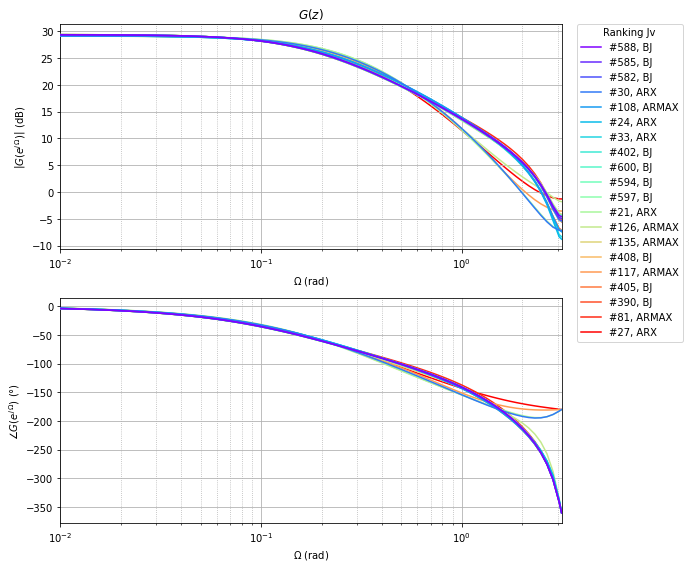

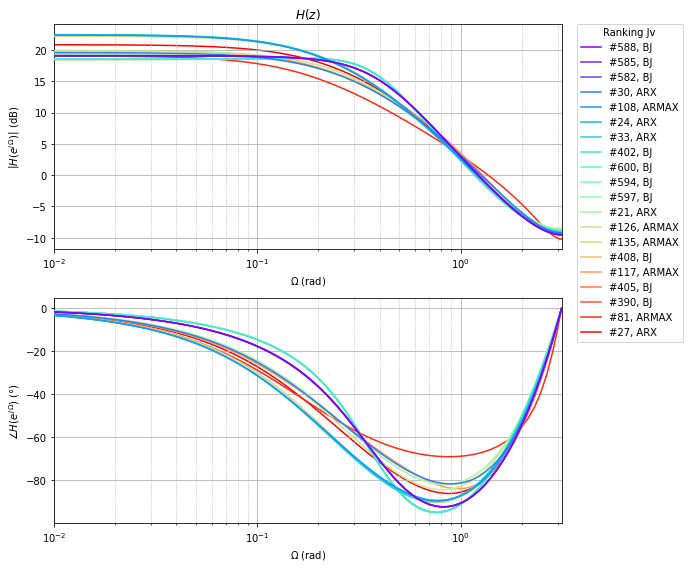

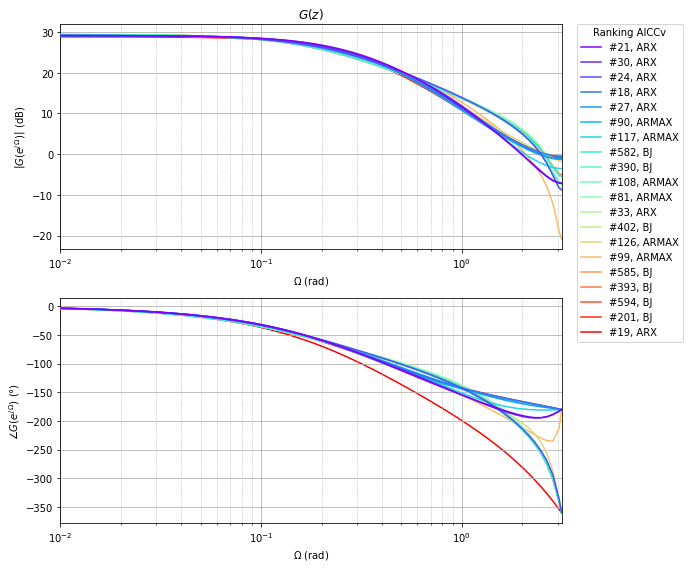

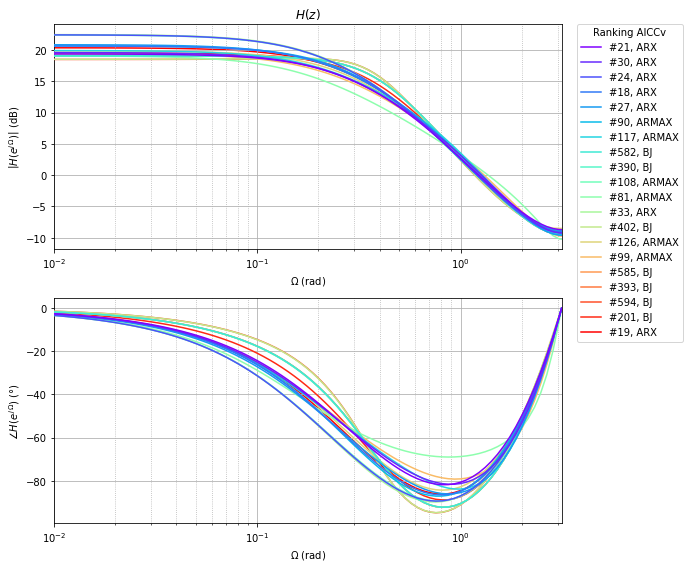

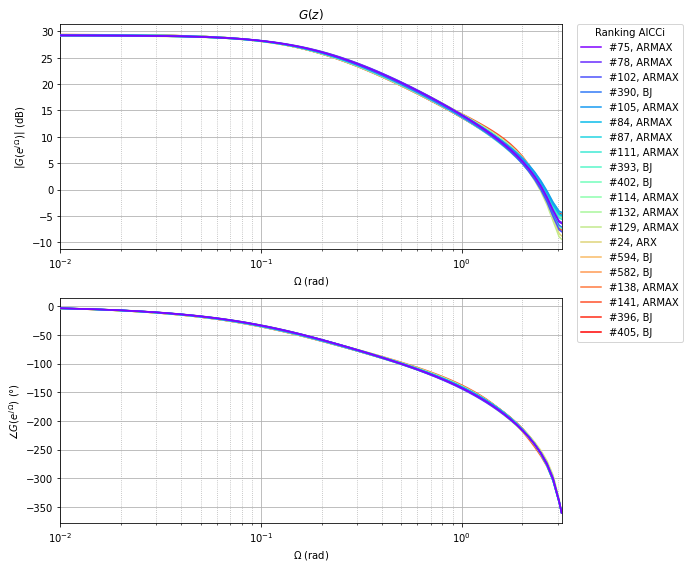

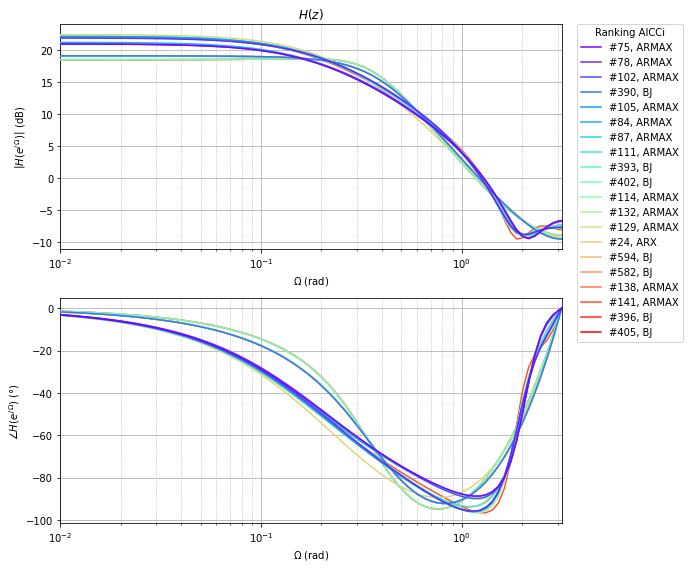

In [15]:
logspace = np.logspace(-2, 1, 100)
logspace = np.append(logspace[logspace < np.pi], np.pi)

qty = 20
for criterion in ['Jv', 'AICCv', 'AICCi']:
  for tf in ['G', 'H']:
    fig, axs = plt.subplots(2, 1, figsize=(8,8))
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, qty)))
    for i, (index, model) in enumerate(models.sort_values(by=[criterion]).iterrows()):
      if i >= qty:
        break
      color = next(colors)
      mag, phase, omega = frequency_response(model[tf], omega=logspace)
      axs[0].plot(omega, mag2db(mag), c=color, zorder=qty-i)
      axs[1].plot(omega, 180/np.pi*np.unwrap(phase), c=color, zorder=qty-i, label=f"#{index}, {model.model}")

    for ax in axs:
      ax.set_xscale('log')
      ax.set_xlim(omega[0], omega[-1])
      ax.grid(which='major')
      ax.grid(which='minor', linestyle=':')
      ax.set_xlabel('$\\Omega$ (rad)')
    axs[0].set_title(f'${tf}(z)$')
    axs[0].set_ylabel(f'$\\left| {tf}\\left(e^{{j \\, \\Omega}}\\right) \\right|$ (dB)')
    axs[1].set_ylabel(f'$\\angle{{{tf}\\left(e^{{j \\, \\Omega}}\\right)}}$ (°)')
    fig.legend(title=f'Ranking {criterion}', bbox_to_anchor=(1.2, 0.96))
    plt.tight_layout()
    plt.show()

## Pole Zero Map

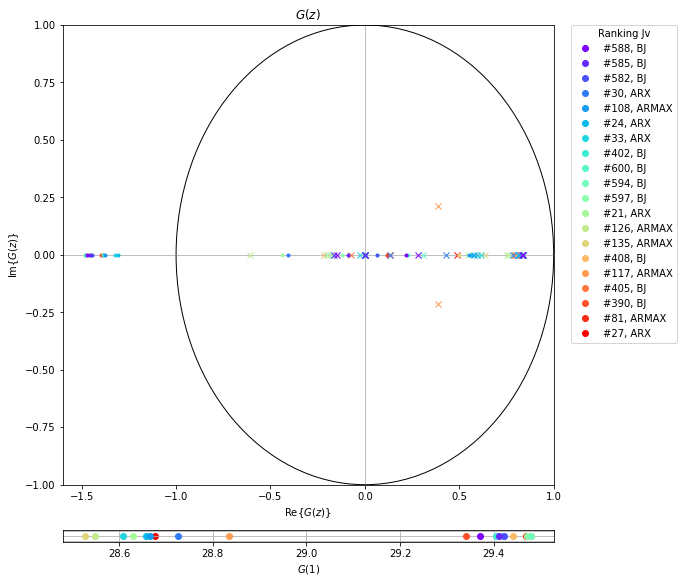

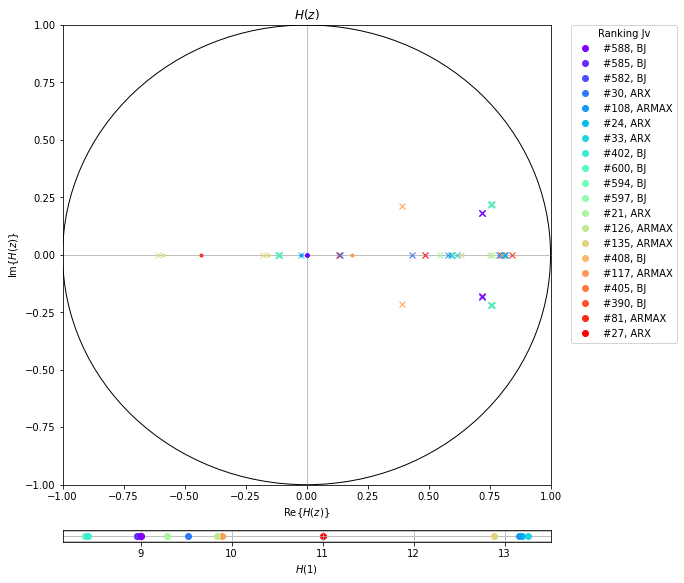

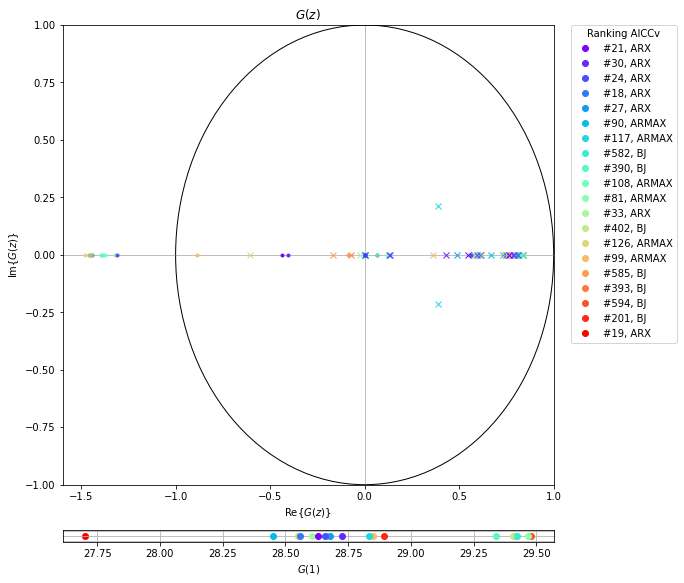

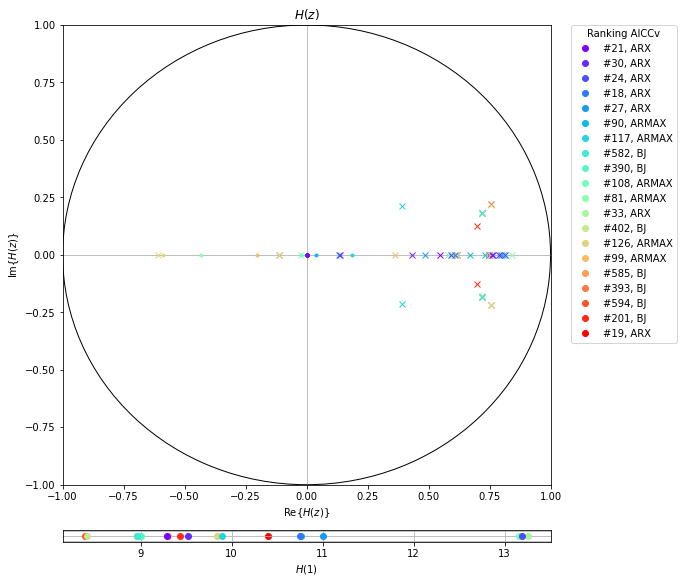

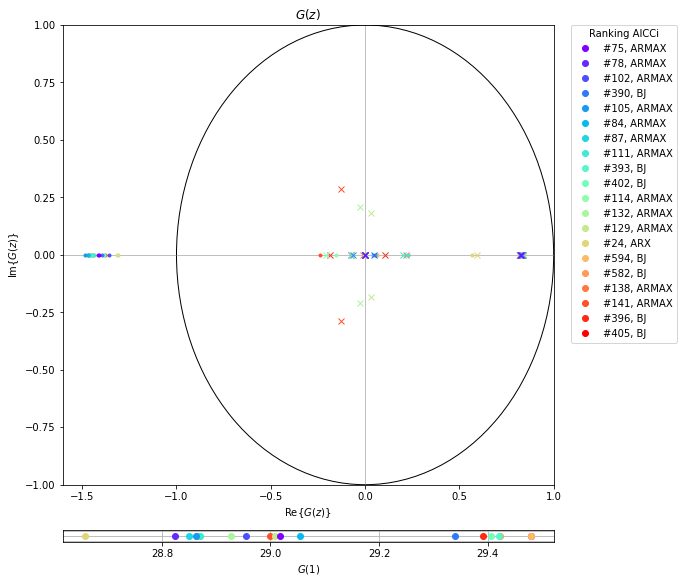

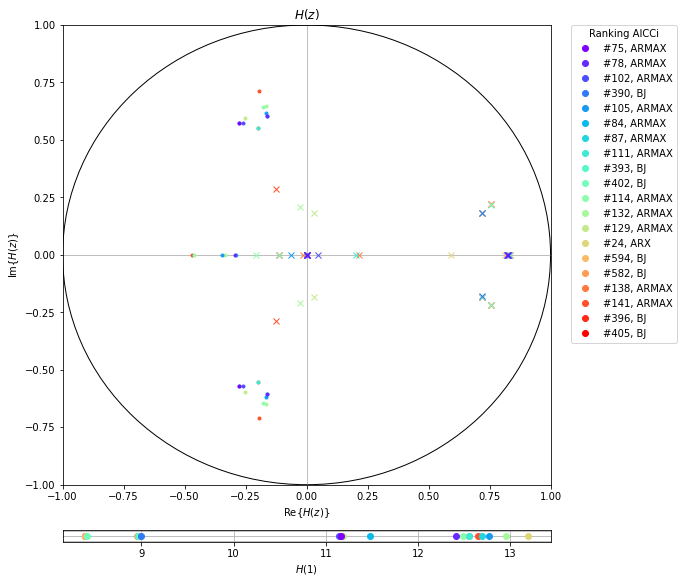

In [16]:
qty = 20
for criterion in ['Jv', 'AICCv', 'AICCi']:
  for tf in ['G', 'H']:
    fig, ax = plt.subplots(2, 1, figsize=(8,8.2), height_ratios=[8, 0.2])
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, qty)))
    for i, (index, model) in enumerate(models.sort_values(by=[criterion]).iterrows()):
      if i >= qty:
        break
      color = next(colors)
      for pole in model[f'p{tf}']:
        ax[0].plot(pole.real, pole.imag, 'x', c=color, zorder=qty-i)
      for zero in model[f'z{tf}']:
        ax[0].plot(zero.real, zero.imag, '.', c=color, zorder=qty-i)
      ax[1].plot(model[f'k{tf}'], 0, 'o', c=color, zorder=qty-i, label=f"#{index}, {model.model}")

    ax[0].set_title(f'${tf}(z)$')
    ax[1].set_xlabel(f'${tf}(1)$')
    ax[0].add_artist(plt.Circle((0, 0), 1, fill=False))
    ax[0].set_xlabel(f'$\\mathrm{{Re}}\\{{{tf}(z)\\}}$')
    ax[0].set_ylabel(f'$\\mathrm{{Im}}\\{{{tf}(z)\\}}$')
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()
    ax[0].set_xlim(min(xlim[0], -1), max(xlim[1], 1))
    ax[0].set_ylim(min(ylim[0], -1), max(ylim[1], 1))
    ax[0].axhline(0, color='gray', linewidth=0.5)
    ax[0].axvline(0, color='gray', linewidth=0.5)
    ax[1].tick_params(axis='y',left=False, labelleft=False)
    ax[1].grid()
    fig.legend(title=f'Ranking {criterion}', bbox_to_anchor=(1.19, 0.96))
    plt.tight_layout()
    plt.show()

## Static Gains Scatter

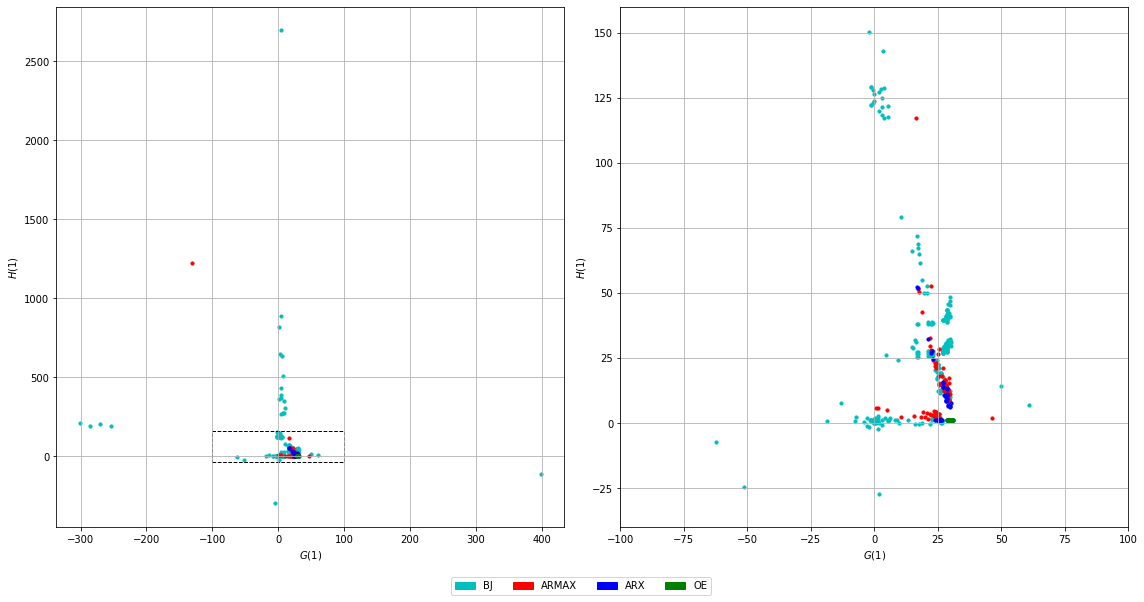

In [17]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 2, figsize=(16,8))

for i in range(0, 1+1):
  ax[i].scatter(models.loc[models.model == 'BJ'   ].kG, models.loc[models.model == 'BJ'   ].kH, s=10, color='c')
  ax[i].scatter(models.loc[models.model == 'ARMAX'].kG, models.loc[models.model == 'ARMAX'].kH, s=10, color='r')
  ax[i].scatter(models.loc[models.model == 'ARX'  ].kG, models.loc[models.model == 'ARX'  ].kH, s=10, color='b')
  ax[i].scatter(models.loc[models.model == 'OE'   ].kG, models.loc[models.model == 'OE'   ].kH, s=10, color='g')
  ax[i].set_xlabel('$G(1)$')
  ax[i].set_ylabel('$H(1)$')
  ax[i].grid()

ax[0].add_patch(plt.Rectangle((-100,-40), 200, 200, fill=False, linestyle='--'))

ax[1].set_xlim((-100, 100))
ax[1].set_ylim((-40, 160))

fig.legend(ncols=4, bbox_to_anchor=(0.625, 0), handles=[
  mpatches.Patch(label='BJ',    color='c'),
  mpatches.Patch(label='ARMAX', color='r'),
  mpatches.Patch(label='ARX',   color='b'),
  mpatches.Patch(label='OE',    color='g'),
])
plt.tight_layout()
plt.show()

## Predictions

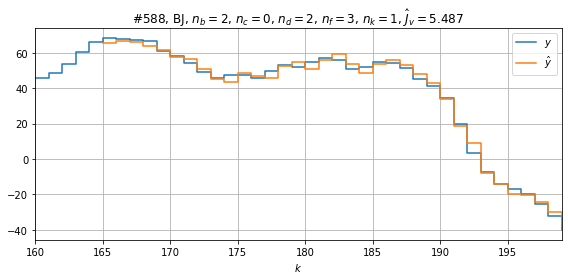

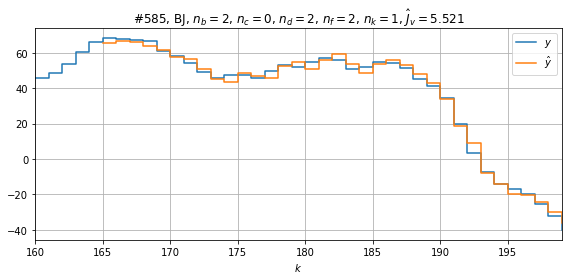

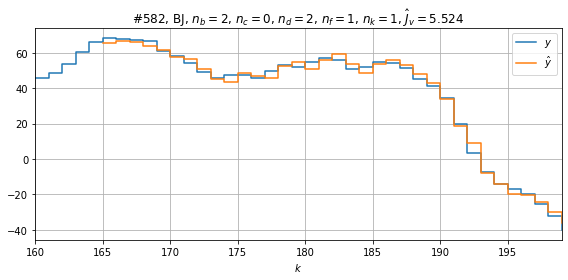

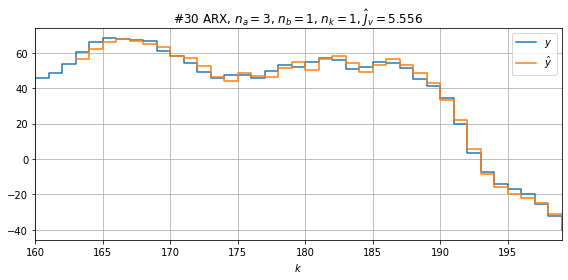

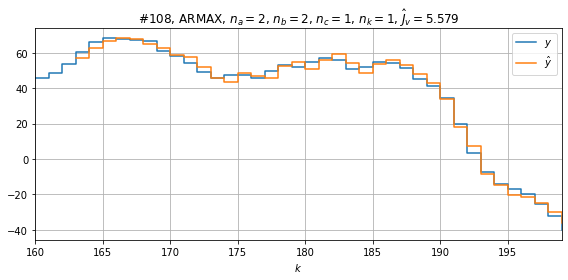

In [18]:
qty = 5
for i, (index, model) in enumerate(models.sort_values(by=['Jv']).iterrows()):
  if i >= qty:
    break

  if np.isnan(model.yp).any():
    continue

  if model.model == 'ARX':
    title = f'#{index} {model.model}, $n_a={model.na}$, $n_b={model.nb}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'ARMAX':
    title = f'#{index}, {model.model}, $n_a={model.na}$, $n_b={model.nb}$, $n_c={model.nc}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'OE':
    title = f'#{index}, {model.model}, $n_b={model.nb}$, $n_f={model.nf}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  elif model.model == 'BJ':
    title = f'#{index}, {model.model}, $n_b={model.nb}$, $n_c={model.nc}$, $n_d={model.nd}$, $n_f={model.nf}$, $n_k={model.nk}$, $\hat{{J}}_v={model.Jv:.4g}$'
  else:
    assert(False)

  plt.figure(figsize=(8,4))
  plt.title(title)
  plt.plot(k_v, y_v, label='$y$', drawstyle='steps-post')
  plt.plot(k_v[int(model.delay):], model.yp, label='$\\hat{y}$', drawstyle='steps-post')
  plt.xlim(k_v[0], k_v[-1])
  plt.xlabel('$k$')
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

# Model in Class

In [19]:
from control import TransferFunction

model = models.loc[(models.model == 'ARX') & (models.na == 2) & (models.nb == 2) & (models.nk == 1)]
assert(len(model) == 1)
model = model.iloc[0]

G0 = TransferFunction.minreal(TransferFunction([2, 2, -1.5], [1, -1.4, 0.48, 0], dt=True))
H0 = TransferFunction.minreal(TransferFunction([1, 0, 0, 0], [1, -1.4, 0.48, 0], dt=True))

print('G_0 =')
display(G0)
print('G =')
display(model.G)

print('H_0 =')
display(H0)
print('H =')
display(model.H)

print(f'J_v    = {model.Jv:7.3f}')
print(f'J_i    = {model.Ji:7.3f}')
print(f'AIC_v  = {model.AICv:7.3f}')
print(f'AICC_v = {model.AICCv:7.3f}')
print(f'AIC_i  = {model.AICi:7.3f}')
print(f'AICC_i = {model.AICCi:7.3f}')

G_0 =


TransferFunction(array([ 2. ,  2. , -1.5]), array([ 1.  , -1.4 ,  0.48,  0.  ]), True)

G =


TransferFunction(array([ 2.16246556,  1.61084338, -1.6016382 ]), array([ 1.        , -1.40683412,  0.48261202,  0.        ]), True)

H_0 =


TransferFunction(array([1., 0., 0.]), array([ 1.  , -1.4 ,  0.48]), True)

H =


TransferFunction(array([1., 0., 0.]), array([ 1.        , -1.40683412,  0.48261202]), True)

J_v    =   5.589
J_i    =   5.276
AIC_v  =  78.832
AICC_v =  80.596
AIC_i  = 276.114
AICC_i = 276.503


## Compare to Original System

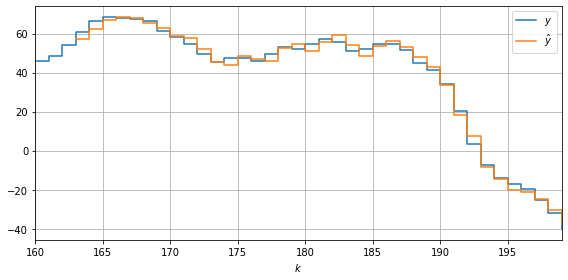

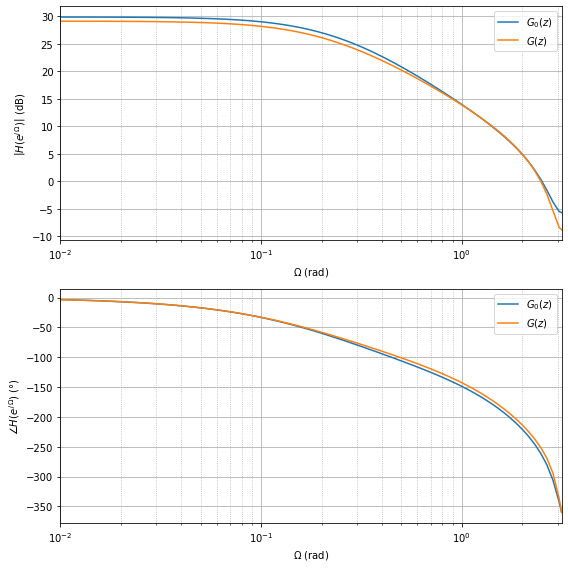

In [20]:
from control import frequency_response, mag2db

plt.figure(figsize=(8,4))
plt.plot(k_v, y_v, label='$y$', drawstyle='steps-post')
plt.plot(k_v[int(model.delay):], model.yp, label='$\\hat{y}$', drawstyle='steps-post')
plt.xlim(k_v[0], k_v[-1])
plt.xlabel('$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

logspace = np.logspace(-2, 1, 100)
logspace = np.append(logspace[logspace < np.pi], np.pi)

mag,  phase,  omega  = frequency_response(model.G, omega=logspace)
mag0, phase0, omega0 = frequency_response(G0,      omega=logspace)

fig, axs = plt.subplots(2, 1, figsize=(8,8))
axs[0].plot(omega0, mag2db(mag0), label = '$G_0(z)$')
axs[1].plot(omega0, 180/np.pi*np.unwrap(phase0), label = '$G_0(z)$')
axs[0].plot(omega,  mag2db(mag), label = '$G(z)$')
axs[1].plot(omega,  180/np.pi*np.unwrap(phase), label = '$G(z)$')
for ax in axs:
  ax.set_xscale('log')
  ax.set_xlim(omega[0], omega[-1])
  ax.grid(which='major')
  ax.grid(which='minor', linestyle=':')
  ax.legend()
  ax.set_xlabel('$\\Omega$ (rad)')
  axs[0].set_ylabel(f'$\\left| {tf}\\left(e^{{j \\, \\Omega}}\\right) \\right|$ (dB)')
  axs[1].set_ylabel(f'$\\angle{{{tf}\\left(e^{{j \\, \\Omega}}\\right)}}$ (°)')
plt.tight_layout()
plt.show()